In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from persim import plot_diagrams

from astropology.distance import pair_wise_distance_matrix
from astropology.series import pd_time_series

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_directory = "/home/edgar/astropology/data/"

lcs = pd.read_csv(
    f"{data_directory}/plasticc_train_lightcurves.csv.gz",
)
meta_data = pd.read_csv(
    f"{data_directory}/plasticc_train_metadata.csv.gz",
)

In [3]:
lcs.head()
# lcs.shape
# np.unique(lcs["detected_bool"])
# np.sum(lcs["detected_bool"]==1), np.sum(lcs["detected_bool"]==0)

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [4]:
u_band = lcs[lcs['passband']==0]
g_band = lcs[lcs['passband']==1]
r_band = lcs[lcs['passband']==2]
i_band = lcs[lcs['passband']==3]
z_band = lcs[lcs['passband']==4]
y_band = lcs[lcs['passband']==5]

print(
    u_band.shape, g_band.shape, r_band.shape,
    i_band.shape, z_band.shape, y_band.shape
)

(197493, 6) (176499, 6) (238049, 6) (233520, 6) (277119, 6) (299025, 6)


In [5]:
np.unique(u_band['object_id']).shape
for object_id in np.unique(u_band['object_id']):

    id_mask = object_id == u_band['object_id']
    print(np.sum(u_band["detected_bool"]==1))
    print(np.sum(u_band["detected_bool"]==0))
    break

17589
179904


In [6]:
u_lcs = {}
u_lcs_mjd = {}
for object_id in np.unique(u_band['object_id']):
    
    id_mask = object_id == u_band['object_id']

    u_lcs[f"{object_id}"] = u_band.loc[id_mask, "flux"].to_numpy()
    u_lcs_mjd[f"{object_id}"] = u_band.loc[id_mask, "mjd"].to_numpy()

In [7]:
# # set to zero negative values
# for _, value in u_lcs.items():
    
#     value[value < 0] = 0

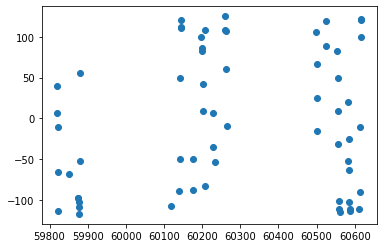

In [8]:
plt.scatter(u_lcs_mjd["615"], u_lcs["615"])

In [11]:
len(u_lcs)

7848

In [10]:
pdgm_lcs = []
pdgm_lcs_normalized = []
idx_objid = {}
for idx, (object_id, lc) in enumerate(u_lcs.items()):

    idx_objid[f"{idx}"] = object_id
    
    pdgm = pd_time_series(lc)
    pdgm_lcs.append(pdgm)
    
    lc_normalized = lc / np.nanmean(lc)
    pdgm_normalized = pd_time_series(lc_normalized)
    pdgm_lcs_normalized.append(pdgm_normalized)

In [107]:
%%time
w_matrix = pair_wise_distance_matrix(
    pdgm_lcs[:1_000], distance="wasserstein"
) 

CPU times: user 1min 9s, sys: 3.98 ms, total: 1min 9s
Wall time: 1min 9s


In [108]:
%%time
w_matrix_normalized = pair_wise_distance_matrix(
    pdgm_lcs_normalized[:1_000], distance="wasserstein"
) 

CPU times: user 1min 9s, sys: 4 ms, total: 1min 9s
Wall time: 1min 9s


In [109]:
w_similarity = np.mean(w_matrix, axis=1)
anomaly_rank = np.argsort(w_similarity)
normalized_w_similarity = np.mean(w_matrix_normalized, axis=1)
normalized_anomaly_rank = np.argsort(normalized_w_similarity)

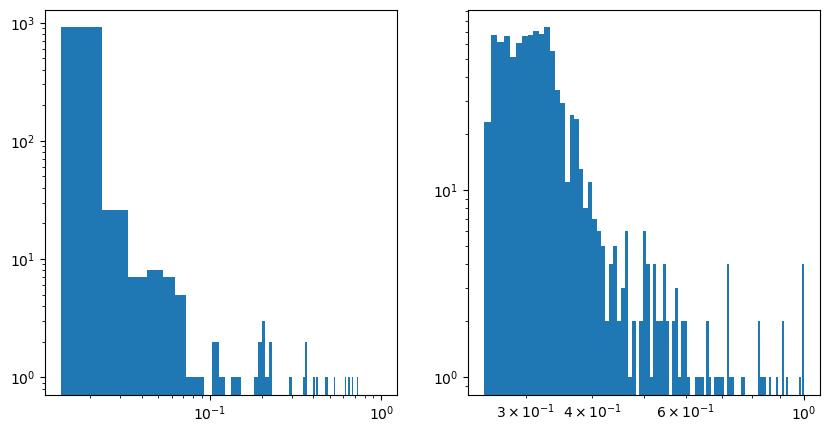

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
_ = axs[0].hist(
    w_similarity/w_similarity.max(),
    bins=100
)
_ = axs[1].hist(
    normalized_w_similarity/normalized_w_similarity.max(),
    bins=100
)
_ = [ax.set_xscale('log') for ax in axs]
_ = [ax.set_yscale('log') for ax in axs]


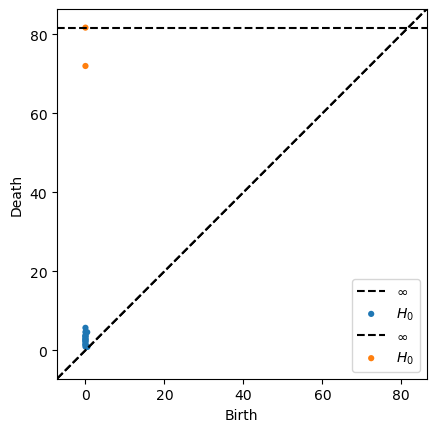

In [111]:
rank = -1
plot_diagrams(pdgm_lcs[anomaly_rank[rank]])
plot_diagrams(pdgm_lcs_normalized[normalized_anomaly_rank[rank]])


61407


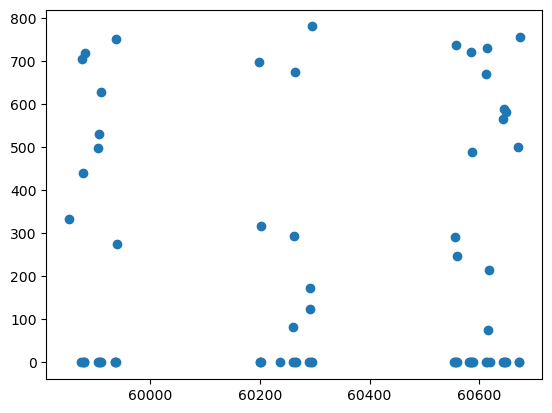

In [99]:
object_id = idx_objid[f"{anomaly_rank[-10]}"]
print(object_id)
lc = u_lcs[object_id]
mjd = u_lcs_mjd[object_id]
plt.scatter(mjd, lc)

110257


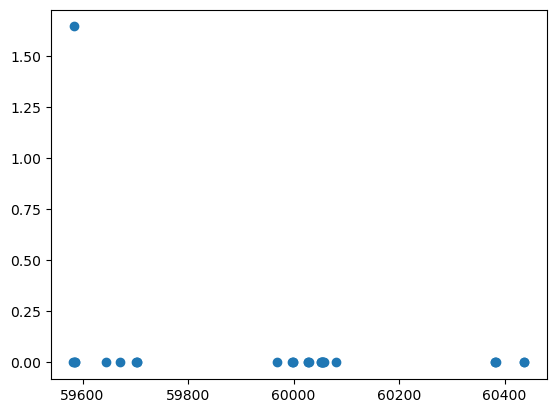

In [112]:
object_id = idx_objid[f"{normalized_anomaly_rank[-50]}"]
print(object_id)
lc = u_lcs[object_id]
mjd = u_lcs_mjd[object_id]
plt.scatter(mjd, lc)